# This notebook implements the BILP-Q tutorial in Cirq

In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq
import cirq_google
from Utils_CSG import *
import sympy 
import numpy as np
from typing import Sequence, Tuple
from cirq.circuits import InsertStrategy
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

## Starting with the a given CSG
Using the same steps as in the BILP-Q Qiskit tutorial to generate the Q-matrix

In [2]:
coalition_values={
    '1':30,
    '2':40,
    '3':25,
    '1,2':70,
    '1,3':60,
    '2,3':65,
    '1,2,3':90
}
coalition_values

{'1': 30, '2': 40, '3': 25, '1,2': 70, '1,3': 60, '2,3': 65, '1,2,3': 90}

In [3]:
c,S,b = convert_to_BILP(coalition_values)       # A function in Utils_CSG.py
print(f'c = {c}\nS = {S}\nb = {b}')

c = [30, 40, 25, 70, 60, 65, 90]
S = [[1, 0, 0, 1, 1, 0, 1], [0, 1, 0, 1, 0, 1, 1], [0, 0, 1, 0, 1, 1, 1]]
b = [1, 1, 1]


In [4]:
qubo_penalty = 50 * -1

linear,quadratic = get_QUBO_coeffs(c,S,b,qubo_penalty)        # A function in Utils_CSG.py

print(f"Linear Coefficients = {linear} \n Quadratic Coefficients = {quadratic}")

Linear Coefficients = {'x_6': -240.0, 'x_3': -170.0, 'x_4': -160.0, 'x_5': -165.0, 'x_0': -80.0, 'x_1': -90.0, 'x_2': -75.0} 
 Quadratic Coefficients = {('x_3', 'x_6'): 200.0, ('x_4', 'x_6'): 200.0, ('x_5', 'x_6'): 200.0, ('x_0', 'x_3'): 100.0, ('x_0', 'x_4'): 100.0, ('x_0', 'x_6'): 100.0, ('x_1', 'x_3'): 100.0, ('x_1', 'x_5'): 100.0, ('x_1', 'x_6'): 100.0, ('x_2', 'x_4'): 100.0, ('x_2', 'x_5'): 100.0, ('x_2', 'x_6'): 100.0, ('x_3', 'x_4'): 100.0, ('x_3', 'x_5'): 100.0, ('x_4', 'x_5'): 100.0}


In [60]:
Q = np.zeros([len(linear),len(linear)])

#diagonal elements
for key,value in linear.items():
    Q[int(key.split('_')[1]),int(key.split('_')[1])] = value

#non diagonal elements
for key,value in quadratic.items():
    Q[int(key[0].split('_')[1]),int(key[1].split('_')[1])] = value/2
    Q[int(key[1].split('_')[1]),int(key[0].split('_')[1])] = value/2

Q = Q/240
Q.round(4)
#I with "non normalized" values, the circuit will end up in just equal superpositions of a set of qubits"

7

## Initializing the circuit

There are many other ways to create circuts. Worth mentioning is that cirq can also create grid-circuits and check, whether all two-qubits gates are only applied to adjacent qubits. This can be usefull when implementing for real quantum devices (D-Wave part).

In [56]:
def cirq_init(n_prob):
    """Initializes a circuit of n_prob Line Qubits in equal superposition"""
    circuit = cirq.Circuit() #initializing a circuit object
    qubits = cirq.LineQubit.range(n_prob) # creating n_prob qubits
    circuit.append(cirq.H(q) for q in qubits) # adding the just created qubits each with a H-Gate to the circuit
    return circuit

## Creating cost and mixer layers

In [49]:
# the mixer layer should just be a list of X rotation gates with parameter beta on each qubit
# that will be appended to the circuit

def mixer(in_circuit, beta_value: float):
    """Adds a mixer layer to circuit with parameter beta_value"""
    circuit = in_circuit.copy() 
    # without copy() circuit would still be the same instance of in_circuit
    # and mixer() would in-place change in_circuit
    
    n_qubits = len(circuit.get_independent_qubit_sets())
    circuit.append([cirq.X(q) ** beta_value for q in qubits],  strategy=InsertStrategy.NEW_THEN_INLINE)
    # adding an X-gate to the power of beta_value to every qubit. Using an insert strategy to put them all in the same moment
    # for better readability in the diagram later
    return circuit

In [57]:
def cost(in_circuit:cirq.circuits.circuit.Circuit, gamma_value:float, Q:np.ndarray) -> cirq.circuits.circuit.Circuit:
    """Adds the cost layer defined by QUBO matrix Q to circuit with the parameter gamma_value"""
    
    
    circuit = in_circuit.copy()
    nrow = np. size(Q, 0)
    ncol = np. size(Q, 1)
    
    # in the Q matrix, diagonal entries represent the coefficients for linear terms, while the of-diagonal non-zero elements
    # are the coefficients for mixed terms. A linear term will be implemented as Z rotation gate on the resprective qubit,
    # while a mixed term is implemented as ZZ rotational gate on the 2 resprective qubits.
    # the rotations are parametrized by the gamma_value for this sprecific layer
    
    for row in range(nrow):
        # we don't need to iterrate through the whole matrix, since it's symetrical. The upper right part and diagonal is enough
        for col in range(row, ncol):
            
            if row == col:
                lin = Q[row,col]
                continue 
                # if the element is on the diagonal we will collect the coefficient to apply the single Z gate after all
                # ZZ gates are done on this qubit
            
            elif Q[row,col] != 0:
                # when we have a non-diagonal element that is not zero we append a gama_value
                # parametrized ZZ rotation gate on the resprective 2 qubits
                circuit.append(cirq.ZZ(qubits[row],qubits[col]) ** (gamma_value * Q[row,col]))
        # the single qubit z gate for linear terms at the end of all ZZ gate for this qubit 
        if lin != 0:
            circuit.append(cirq.Z(qubits[row]) ** (gamma_value * lin))
                  
    return circuit

## Creating the circuit
Note: the layer-functions still change the circuit in-place

In [67]:
p = 1 # number of layers

# Parameters are introduced as 'symbols'. Symbols can be used like variables in a circuit but need to be 'resolved'
# (get a value assigned to) when we want to simulate or run the circuit
beta = [sympy.Symbol("β_"+str(i)) for i in range(p)]
gamma = [sympy.Symbol("γ_"+str(i)) for i in range(p)]
print(beta, gamma)

[β_0, β_1] [γ_0, γ_1]


In [68]:
problem_size = len(Q[0])
qaoa = cirq_init(problem_size)
for i in range(p):
    
    qaoa = cost(qaoa, gamma[i], Q)
    
    qaoa = mixer(qaoa, beta[i])

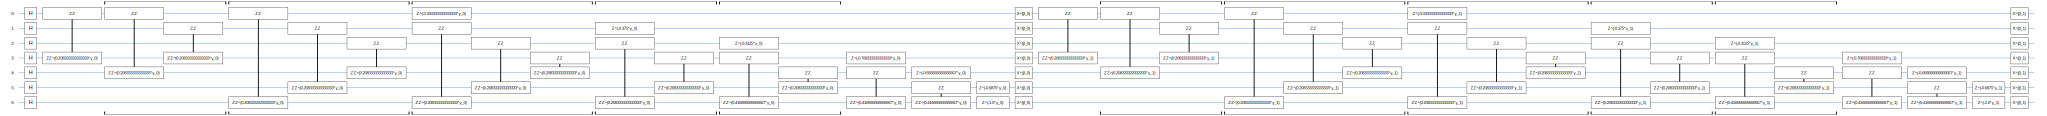

In [69]:
# better printing with SVG
SVGCircuit(qaoa)

In [45]:
def f_params(gamma, beta, circuit):
    simulator = cirq.Simulator()
    params = cirq.ParamResolver({"γ_0": gamma, "β_0": beta})
    result = simulator.simulate(circuit, param_resolver=params).final_state_vector
    psum = [cirq.X(q) for q in cirq.LineQubit(range(circuit.get_independent_qubit_sets()))]
    return NULL
 

#energy for these parameters?

In [70]:
cK = qaoa.copy()
psum = [q for q in cirq.LineQubit.range(len(cK.get_independent_qubit_sets()))]
psum
len(cK.get_independent_qubit_sets())

1

In [14]:
def f_params2(gamma, beta, circuit, qubo):
    simulator = cirq.Simulator()
    params = cirq.ParamResolver({"γ_0": gamma, "β_0": beta})
    result = simulator.simulate(circuit, param_resolver=params).final_state_vector
    return result

abs(f_params2(0.5, 1.2, qaoa, Q))

array([0.24829431, 0.2598409 , 0.19695954, 0.02798445, 0.19374515,
       0.0281924 , 0.05228798, 0.04972458, 0.19944829, 0.02769398,
       0.05341419, 0.04973387, 0.05269067, 0.04952716, 0.03322382,
       0.04056416, 0.19553907, 0.13284555, 0.13746484, 0.06344684,
       0.13683528, 0.06475646, 0.0877848 , 0.08751667, 0.10785784,
       0.01889781, 0.04143078, 0.04499561, 0.04204051, 0.0450269 ,
       0.03590188, 0.07434941, 0.1918486 , 0.12540579, 0.13000198,
       0.061402  , 0.10183844, 0.02063151, 0.03918939, 0.04375733,
       0.13002406, 0.05980889, 0.08280346, 0.08123972, 0.03832516,
       0.04333277, 0.03439279, 0.07057536, 0.12316817, 0.05941253,
       0.10727008, 0.07860016, 0.06177879, 0.03925319, 0.06069974,
       0.08288459, 0.06022229, 0.03865474, 0.06002556, 0.08035436,
       0.03055371, 0.03874352, 0.03623766, 0.11436408, 0.19444725,
       0.13043027, 0.10541242, 0.02003678, 0.13446337, 0.06417578,
       0.04141438, 0.0450315 , 0.13511826, 0.06123577, 0.03993

In [15]:
for i in range(0, 20, 1):
    for j in range(0, 20, 1):
        print(f_params(i/10,j/10,qaoa))
        
#parameters don't influence energy :(

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 128)

In [ ]:
# Adding a measurement layer
measure_qoao = qaoa.copy()
measure_qoao.append(cirq.measure(qubits, key = 'result'))

In [ ]:
num_reps = 1000
#single instance of parameters
gamma_value, beta_value = 1, 1 
simulator = cirq.Simulator()
params = cirq.ParamResolver({"γ_0": gamma_value, "β_0": beta_value})
measure_result = simulator.run(measure_qoao, param_resolver=params, repetitions = num_reps)
  
cirq.plot_state_histogram(measure_result, plt.subplot())
plt.show()
